In [0]:
!pip install concise

In [204]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [205]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [0]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold

# tf.python.control_flow_ops = tf


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl

mpl.use('Agg')
# from keras.utils.layer_utils import print_layer_shapes

import utils
sys.path.append(".")
from utils import load_data_merged
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *

from tensorflow.python.keras.backend import set_session

model_path = "./models/final.h5"

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 
%matplotlib inline



In [0]:
_, _, _, _, x_test_seq, y_test = load_data_merged(r"dataset/solo_test_with_crc10_var_0.05.pkl", 150, False)

In [0]:
import re
ss_re = re.compile("[CG]CG[CG]")
ww_re = re.compile("[AT]CG[AT]")

In [0]:
def vecs2dna(seq_vecs):
    seqs = []
    # seq_vecs = np.reshape(seq_vecs, (seq_vecs.shape[0], 4, -1))
    for i in range(seq_vecs.shape[0]):
        seq_list = [''] * seq_vecs.shape[1]
        for j in range(seq_vecs.shape[1]):
            if seq_vecs[i, j,0] > 0:
                seq_list[j] = 'A'
            elif seq_vecs[i, j, 1] >0:
                seq_list[j] = 'C'
            elif seq_vecs[i, j, 2] >0:
                seq_list[j] = 'G'
            elif seq_vecs[i, j, 3] >0 :
                seq_list[j] = 'T'
            else:
                print("problem")

        seqs.append(''.join(seq_list))

    return seqs

def get_ex_ind(predict_label, thr=0.5, with_pred=False):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(x_test_seq)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]==predict_label and pred[i[0]] > thr:
            ind.append(i[0])
  
  if with_pred:
    return ind, pred[ind]
  
  else:
    return ind

def get_prediction(data):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:

        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(data)

  return pred

In [0]:
def get_refrence_list_zeros_flank_1(seq_example):
    rf = np.zeros(seq_example.shape)
    m = int(seq_example.shape[0]/ 2 - 1)
    for i in range(-2,2):
      rf[m-i] = seq_example[m-i]
    return rf

def get_ex_seq(data, predict_label, number_of_seq, thr=0.5):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(data)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]==predict_label and pred[i[0]] > thr:
            ind.append(i[0])
        
        if number_of_seq != -1:
          ind = ind[:number_of_seq]
        
        gradients = integrated_gradients(model) 
        ex_seq=np.array([gradients.explain([x_test_seq[i]],reference=[get_refrence_list_zeros_flank_1(x_test_seq[i])],num_steps=100)[0] for i in ind])

        if predict_label == CLASS_PARTIAL_LOSS:
          ex_seq = ex_seq * -1
  
  return ex_seq

CL changing flanks

In [0]:
cl_ind = get_ex_ind(CLASS_COMPLETELY_LOSS,thr=0.5)
cl_array = np.array([x_test_seq[i] for i in cl_ind])
cl_seq = vecs2dna(cl_array)

acga = []
acgt = []
tcgt = []
tcga = []

for seq in cl_seq:
  if "ACGA" in seq:
    acga.append(seq)
  elif "ACGT" in seq:
    acgt.append(seq)
  elif "TCGT" in seq:
    tcgt.append(seq)
  elif "TCGA" in seq:
    tcga.append(seq)
  else:
    pass

In [0]:
import seaborn as sns
plt.style.use('seaborn')

def calculate_flank_changes_ww_to_ss(seq_list, original_seq):
  original_seq = original_seq.upper()
  seq_array = np.array([seq_to_mat(i) for i in seq_list])
  original_pred = get_prediction(seq_array)
  letters = ["A","C","G","T"]
  letters.remove(original_seq[0])
  d = {original_seq:original_pred}
  for letter in letters:
    new_flank = letter+ original_seq[1:]
    new_seq = [seq.replace(original_seq, new_flank) for seq in seq_list]  
    new_array = np.array([seq_to_mat(i) for i in new_seq])
    new_pred = get_prediction(new_array)
    # plt.scatter(x=original_pred, y=new_pred, label="%s-->%s" %(original_seq, new_flank), alpha=0.4, marker='o', s=0.1)
    # sns.kdeplot(original_pred, new_pred, cmap="Reds", shade=True)
    # sns.distplot(new_pred, hist=False, kde=True, kde_kws={'linewidth': 3}, label=new_flank)
    d[new_flank] = new_pred
        

  # plt.xlim(0,1,0.1)
  # plt.ylim(0,1,0.1)
  # plt.legend()
  # plt.show()
  return d

In [201]:
acgt_dict = calculate_flank_changes_ww_to_ss(acgt, "ACGT")
acga_dict = calculate_flank_changes_ww_to_ss(acgt, "ACGA")
tcga_dict = calculate_flank_changes_ww_to_ss(acgt, "TCGA")
tcgt_dict = calculate_flank_changes_ww_to_ss(acgt, "TCGT")

KeyboardInterrupt: ignored

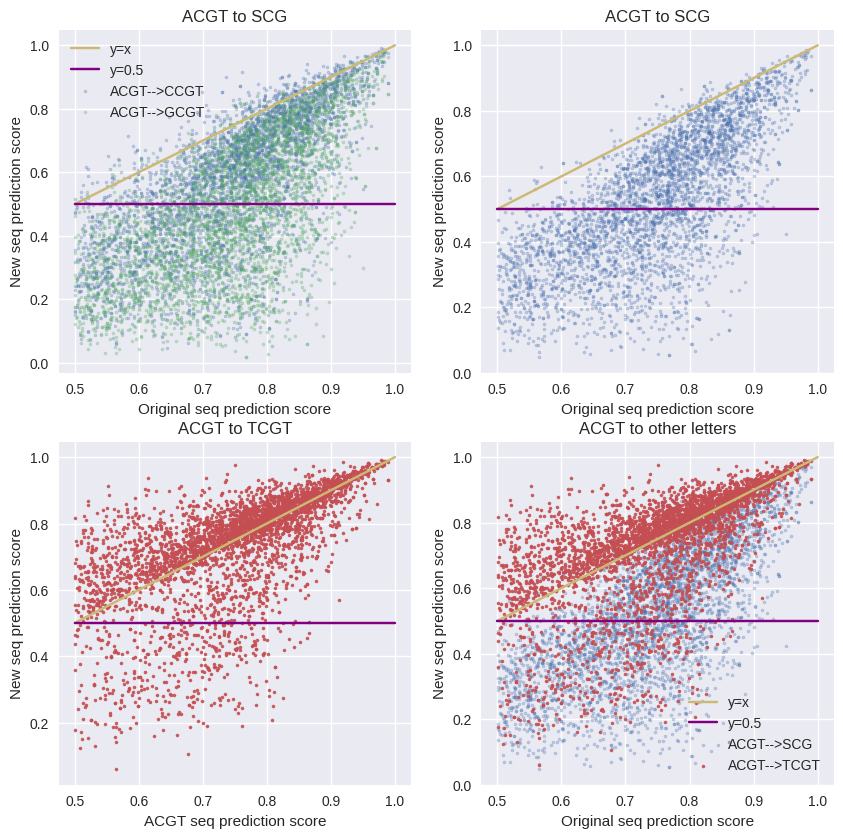

In [202]:
from matplotlib.lines import Line2D   
fig = plt.figure(figsize=(10,10), dpi=100)

# W to S 

ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="y", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="purple", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

for k in acgt_dict:
  if k != original_flank and k != "TCGT":
    plt.scatter(x=acgt_dict[original_flank], y=acgt_dict[k], label="%s-->%s" %(original_flank, k), marker='.', s=20, alpha=0.3)
    plt.title("%s to SCG" %original_flank)
    plt.legend()

plt.xlabel("Original seq prediction score")
plt.ylabel("New seq prediction score")


# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="y", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="purple", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict["GCGT"] + acgt_dict["CCGT"]
a = a / 2
plt.scatter(x=acgt_dict[original_flank], y=a, label="%s-->%s" %(original_flank, "SCG"), marker='.', s=20, alpha=0.3)
plt.title("ACGT to SCG")
# plt.legend()

plt.xlabel("Original seq prediction score")
plt.ylabel("New seq prediction score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="y", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="purple", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict[original_flank], y=acgt_dict["TCGT"], label="%s-->%s" %(original_flank, "TCGT"), marker='.', s=20, alpha=0.9, c="r")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("ACGT seq prediction score")
plt.ylabel("New seq prediction score")


# Both
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="y", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="purple", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

# for k in acgt_dict:
#   if k != original_flank:
plt.scatter(x=acgt_dict[original_flank], y=a, label="%s-->%s" %(original_flank, "SCG"), marker='.', s=20, alpha=0.3, c="b")
plt.scatter(x=acgt_dict[original_flank], y=acgt_dict["TCGT"], label="%s-->%s" %(original_flank, "TCGT"), marker='.', s=20, alpha=0.9, c="r")
plt.title("%s to other letters" % original_flank)

plt.legend()
plt.xlabel("Original seq prediction score")
plt.ylabel("New seq prediction score")


plt.show()

In [0]:
# sns.kdeplot(, , cmap="Reds", shade=True)

for k in acgt_dict:
  if k != original_flank:
    sns.jointplot(x=acgt_dict[original_flank], y=acgt_dict[k], kind='kde', label="%s-->%s" %(original_flank, k),)

**Save sequence of predicated correctly **

In [0]:
pred = get_prediction(x_test_seq)

In [0]:
ind = []
for i in range(pred.shape[0]):
  if int(np.round(pred[i])) == y_test[i]:
    ind.append(i)


In [0]:
rel = pred[ind]

In [0]:
with open("./sequence_prediction.pkl", "wb") as f:
  pickle.dump(ar, f)

Change WW to SS total and plot total classificaton kept 

In [0]:
def get_cl_changes(thr):
  # Look at all the CL which are WW and change to SS
  cl_ind = get_ex_ind(CLASS_COMPLETELY_LOSS,thr=thr)
  cl_seq_array = np.array([x_test_seq[i] for i in cl_ind])
  cl_seq = vecs2dna(cl_seq_array)
  cl_ww_seq = [i for i in cl_seq if ww_re.search(i) != None]
  cl_ss_seq = [i for i in cl_seq if ss_re.search(i) !=None]

  cl_ww_to_ss = []
  for seq in cl_ww_seq:
    new_seq = seq[:73] + "CCGC" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "GCGG" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "CCGG" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "GCGC" + seq[77:]
    cl_ww_to_ss.append(new_seq)

  expected = len(cl_ww_to_ss)
  cl_ww_to_ss_arr = np.array([seq_to_mat(i) for i in cl_ww_to_ss])

  pred = get_prediction(cl_ww_to_ss_arr)
  return np.sum(pred>0.5) / expected * 100


In [0]:
thr_to_check = np.arange(0.5,1.0,0.05)
l1 = []
l2 = []

for i in thr_to_check:
  v =i
  l1.append(v)
  l2.append(get_cl_changes(v))

Text(0, 0.5, '% sequences which kept label')

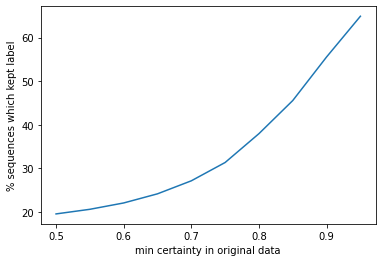

In [0]:
plt.plot(l1,l2)
plt.xlabel("min certainty in original data")
plt.ylabel("% sequences which kept label")

Caclculate CL ww to ss changes and integrated explanation

In [0]:
# len(cl_ss_predicted_cl)
cl_ss_predicted_cl = [cl_ww_to_ss[i] for i in range(pred.shape[0]) if pred[i] > 0.75] + cl_ss_seq
cl_ex_seq = get_ex_seq(np.array([seq_to_mat(i) for i in cl_ss_predicted_cl]),predict_label=CLASS_COMPLETELY_LOSS, number_of_seq=-1, thr=0.75)

In [0]:
# Look at all the PL which are SS and change to WW
pl_ind = get_ex_ind(CLASS_PARTIAL_LOSS, thr=0.75)
pl_seq_array = np.array([x_test_seq[i] for i in pl_ind])

pl_seq = vecs2dna(pl_seq_array)
pl_ww_seq = [i for i in pl_seq if ww_re.search(i) != None]
pl_ss_seq = [i for i in pl_seq if ss_re.search(i) !=None]

pl_ss_to_ww = []
for seq in pl_ss_seq:
  new_seq = seq[:73] + "ACGA" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "ACGT" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "TCGT" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "TCGA" + seq[77:]
  pl_ss_to_ww.append(new_seq)

expected = len(pl_ss_to_ww)
pl_ww_to_ss_arr = np.array([seq_to_mat(i) for i in pl_ss_to_ww])

pred = 1 - get_prediction(pl_ww_to_ss_arr)
np.sum(pred>0.5) / expected * 100

43.34658078662464

In [0]:
# len(cl_ss_predicted_cl)
pl_ww_predicted_pl = [pl_ss_to_ww[i] for i in range(pred.shape[0]) if pred[i] > 0.75] + pl_ww_seq
pl_ex_seq = get_ex_seq(np.array([seq_to_mat(i) for i in pl_ww_predicted_pl]),predict_label=CLASS_PARTIAL_LOSS, number_of_seq=-1, thr=0.75)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [0]:
import pickle

d = {"cl": cl_ex_seq, "pl": pl_ex_seq}

with open("./gradients_explain/kept_prediction_after_changes_1_flank.pkl", "wb") as f:
  pickle.dump(d, f)

Info on reverse strand 

In [0]:
TRANSLATION_TABLE = {84: 65, 65: 84, 67: 71, 71: 67}
pred = get_prediction(x_test_seq)


In [0]:
sequences = vecs2dna(x_test_seq)

TypeError: ignored

In [0]:
import pandas as pd
df = pd.DataFrame()

In [0]:
df["seq"] = sequences
df["pred"] = pred

In [0]:
gb = df.groupby("seq").mean()

In [0]:
values_d = {}
for seq in gb.index:
  reversed_seq = seq.translate(TRANSLATION_TABLE)[::-1] 
  if reversed_seq in values_d:
    continue
  
  values_d[seq] = (gb[gb.index == seq]["pred"][0], gb[gb.index ==reversed_seq]["pred"][0])

In [0]:
a = [i[0] for i in values_d.values()]
b = [i[1] for i in values_d.values()]

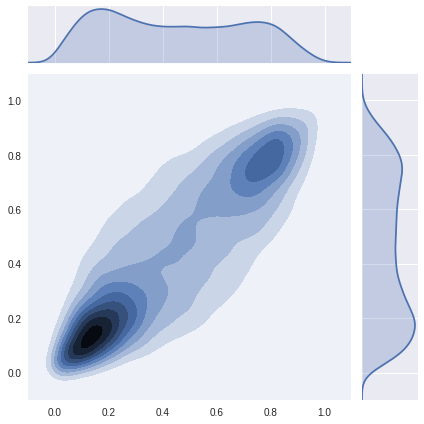

In [281]:
sns.jointplot(x=a, y=b, kind='kde')

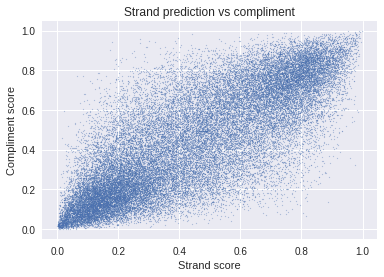

In [287]:
plt.scatter(a,b, marker='o', s=1, alpha=0.3)
plt.title("Strand prediction vs compliment")
plt.xlabel("Strand score")
plt.ylabel("Compliment score")
plt.show()